In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import polars as pl
import scipy.stats as stats
import scipy.sparse as sps
import gc
import tqdm

from ebrec.utils._descriptive_analysis import (
    min_max_impression_time_behaviors, 
    min_max_impression_time_history
)
from ebrec.utils._polars import slice_join_dataframes
from ebrec.utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    truncate_history,
)
from ebrec.utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_USER_COL
)
from polimi.utils._custom import GetMemUsage, PrintColor
from polimi.utils._polars import reduce_polars_df_memory_size
from ebrec.evaluation.metrics_protocols import *
from polimi.utils._catboost import add_trendiness_feature, add_mean_delays_features,add_history_trendiness_scores_feature
from polimi.utils._custom import *

from catboost import CatBoostClassifier

# Data import

In [2]:
from polimi.utils._custom import load_dataset

d_path = Path('../dataset')
preprocessing_path = d_path / 'preprocessing'
train_ds_path = preprocessing_path / 'preprocessing_train_small_127' 
features_path = preprocessing_path / 'preprocessing_urm_ner_scores'

train_ds = pl.read_parquet(train_ds_path / 'train_ds.parquet')
train_info = read_json(train_ds_path / 'data_info.json')

gc.collect()
PrintColor(GetMemUsage())
train_ds.head(3)

RAM memory GB usage = 1.104


impression_id,article,user_id,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,target,trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,article_delay_days,article_delay_hours,Entity_MISC_Present,Entity_ORG_Present,Entity_EVENT_Present,Entity_PROD_Present,Entity_PER_Present,Entity_LOC_Present,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct,…,Category_video_Pct,Category_sex_og_samliv_Pct,Category_nationen_Pct,mean_user_trendiness_score,mean_topics_trendiness_score,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,weighted_mean_JS,mean_topic_model_cosine,min_topic_model_cosine,max_topic_model_cosine,std_topic_model_cosine,weighted_mean_topic_model_cosine,lda_0_history_mean,lda_1_history_mean,lda_2_history_mean,lda_3_history_mean,lda_4_history_mean,lda_0_history_weighted_mean,lda_1_history_weighted_mean,lda_2_history_weighted_mean,lda_3_history_weighted_mean,lda_4_history_weighted_mean
u32,i32,u32,i8,f32,f32,bool,i8,i8,bool,i8,i16,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,u32,i16,i32,bool,bool,bool,bool,bool,bool,i8,f32,i16,bool,bool,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
277442809,9772442,2230398,2,18.0,null,false,2,null,false,0,470,5,13,false,142,0.976,"""Negative""",1,7,19,271,7,0,2,true,true,true,false,true,true,0,0.222222,-6,true,false,0.314286,…,0.0,0.0,0.04359,262.44873,358.13916,5.170502,126.585823,3.738461,91.88974,95,177,104,95,0,1,0,0,49,201,107,1967,0.126245,0.776055,0.451993,0.994692,0.135933,0.766133,0.216578,0.232461,0.155752,0.179385,0.215825,0.227063,0.237563,0.149121,0.179779,0.206474
565799686,9779642,1931088,2,32.0,null,false,2,null,false,0,358,3,19,false,414,0.9227,"""Positive""",1,5,12,114,6,0,2,true,true,false,true,true,true,1,0.666667,8,false,false,0.15942,…,0.0,0.0,0.038462,265.487183,286.338684,15.720451,380.254089,0.00641,2.019231,59,46,29,43,0,0,1,0,2,34,52,1888,0.080581,0.763784,0.456974,0.991503,0.135545,0.754627,0.194253,0.282754,0.134726,0.18098,0.207287,0.188645,0.293603,0.132603,0.179521,0.205628
455099033,9771473,1698364,2,239.0,100.0,false,2,null,false,1,217,5,6,false,414,0.6533,"""Neutral""",1,6,17,189,6,0,1,false,true,false,true,true,true,0,8.0,34,false,false,0.171429,…,0.0,0.0,0.012931,231.702591,232.622467,36.512486,879.912415,9.594828,234.284485,77,95,55,40,1,0,0,0,16,66,51,924,0.078189,0.712615,0.437284,0.998641,0.159516,0.706142,0.217148,0.236107,0.157202,0.179373,0.21017,0.210046,0.246268,0.168206,0.184459,0.191021


## Load features to test

In [3]:
features = pl.read_parquet(features_path / 'train' / 'urm_ner_scores.parquet')
features.head(2)

impression_id,user_id,article,sum_RP3betaRecommender_ner_scores,sum_PureSVDItemRecommender_ner_scores,sum_ItemKNNCFRecommender_ner_scores,sum_MatrixFactorization_BPR_Cython_ner_scores,sum_P3alphaRecommender_ner_scores,max_RP3betaRecommender_ner_scores,max_PureSVDItemRecommender_ner_scores,max_ItemKNNCFRecommender_ner_scores,max_MatrixFactorization_BPR_Cython_ner_scores,max_P3alphaRecommender_ner_scores,mean_RP3betaRecommender_ner_scores,mean_PureSVDItemRecommender_ner_scores,mean_ItemKNNCFRecommender_ner_scores,mean_MatrixFactorization_BPR_Cython_ner_scores,mean_P3alphaRecommender_ner_scores
u32,u32,i32,f32,f32,f32,f64,f32,f32,f32,f32,f64,f32,f32,f32,f32,f64,f32
149474,139836,9778623,0.24191,0.206052,0.22818,1.0,0.289564,1.0,0.961236,0.957081,1.0,0.866281,0.204693,0.174351,0.193075,1.0,0.245015
149474,139836,9778682,0.003335,0.005536,0.008025,0.692308,0.0,0.014159,0.023241,0.032212,1.0,0.0,0.004076,0.006767,0.009809,1.0,0.0


In [4]:
train_ds = train_ds.join(features, on=['impression_id', 'user_id', 'article'], how='left')
train_ds.head(2)

impression_id,article,user_id,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,target,trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,article_delay_days,article_delay_hours,Entity_MISC_Present,Entity_ORG_Present,Entity_EVENT_Present,Entity_PROD_Present,Entity_PER_Present,Entity_LOC_Present,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct,…,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,weighted_mean_JS,mean_topic_model_cosine,min_topic_model_cosine,max_topic_model_cosine,std_topic_model_cosine,weighted_mean_topic_model_cosine,lda_0_history_mean,lda_1_history_mean,lda_2_history_mean,lda_3_history_mean,lda_4_history_mean,lda_0_history_weighted_mean,lda_1_history_weighted_mean,lda_2_history_weighted_mean,lda_3_history_weighted_mean,lda_4_history_weighted_mean,sum_RP3betaRecommender_ner_scores,sum_PureSVDItemRecommender_ner_scores,sum_ItemKNNCFRecommender_ner_scores,sum_MatrixFactorization_BPR_Cython_ner_scores,sum_P3alphaRecommender_ner_scores,max_RP3betaRecommender_ner_scores,max_PureSVDItemRecommender_ner_scores,max_ItemKNNCFRecommender_ner_scores,max_MatrixFactorization_BPR_Cython_ner_scores,max_P3alphaRecommender_ner_scores,mean_RP3betaRecommender_ner_scores,mean_PureSVDItemRecommender_ner_scores,mean_ItemKNNCFRecommender_ner_scores,mean_MatrixFactorization_BPR_Cython_ner_scores,mean_P3alphaRecommender_ner_scores
u32,i32,u32,i8,f32,f32,bool,i8,i8,bool,i8,i16,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,u32,i16,i32,bool,bool,bool,bool,bool,bool,i8,f32,i16,bool,bool,f32,…,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f32,f32,f32,f32,f64,f32,f32,f32,f32,f64,f32
277442809,9772442,2230398,2,18.0,null,false,2,null,false,0,470,5,13,false,142,0.976,"""Negative""",1,7,19,271,7,0,2,true,true,true,false,true,true,0,0.222222,-6,true,false,0.314286,…,0,0,49,201,107,1967,0.126245,0.776055,0.451993,0.994692,0.135933,0.766133,0.216578,0.232461,0.155752,0.179385,0.215825,0.227063,0.237563,0.149121,0.179779,0.206474,0.665582,0.631702,0.647791,0.212766,0.801122,1.0,0.98097,1.0,1.0,1.0,0.499356,0.470239,0.538352,1.0,0.636309
565799686,9779642,1931088,2,32.0,null,false,2,null,false,0,358,3,19,false,414,0.9227,"""Positive""",1,5,12,114,6,0,2,true,true,false,true,true,true,1,0.666667,8,false,false,0.15942,…,1,0,2,34,52,1888,0.080581,0.763784,0.456974,0.991503,0.135545,0.754627,0.194253,0.282754,0.134726,0.18098,0.207287,0.188645,0.293603,0.132603,0.179521,0.205628,0.542368,0.601005,0.55403,0.333333,0.601035,1.0,0.982679,0.996576,1.0,1.0,0.285248,0.30052,0.321149,1.0,0.217943


# Training

In [5]:
train_ds = train_ds.drop(['impression_id', 'article', 'user_id', 'impression_time']).to_pandas()
groups = train_ds['impression_id'].copy()

categorical_columns = train_info['categorical_columns']
train_ds[categorical_columns] = train_ds[categorical_columns].astype('category')

X_train = train_ds.drop(columns=['target'])
y_train = train_ds['target']

In [6]:
del train_ds

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.7766


In [7]:
# just a simple model to be able to run an evaluation
model = CatBoostClassifier(cat_features=categorical_columns, iterations=500)

model.fit(X_train, y_train, verbose=25)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

Learning rate set to 0.5
0:	learn: 0.3499804	total: 1.74s	remaining: 14m 25s
25:	learn: 0.2634046	total: 36.6s	remaining: 11m 6s
50:	learn: 0.2584444	total: 1m 17s	remaining: 11m 23s
75:	learn: 0.2554829	total: 1m 54s	remaining: 10m 40s
100:	learn: 0.2532292	total: 2m 30s	remaining: 9m 56s
125:	learn: 0.2515349	total: 3m 2s	remaining: 9m 1s
150:	learn: 0.2501105	total: 3m 34s	remaining: 8m 15s
175:	learn: 0.2488162	total: 4m 6s	remaining: 7m 33s
200:	learn: 0.2476362	total: 4m 36s	remaining: 6m 51s
225:	learn: 0.2465189	total: 5m 5s	remaining: 6m 10s
250:	learn: 0.2455466	total: 5m 36s	remaining: 5m 33s
275:	learn: 0.2446357	total: 6m 5s	remaining: 4m 56s
300:	learn: 0.2438133	total: 6m 36s	remaining: 4m 21s
325:	learn: 0.2430292	total: 7m 5s	remaining: 3m 47s
350:	learn: 0.2423350	total: 7m 36s	remaining: 3m 13s
375:	learn: 0.2415486	total: 8m 8s	remaining: 2m 41s
400:	learn: 0.2408958	total: 8m 47s	remaining: 2m 10s
425:	learn: 0.2402376	total: 9m 19s	remaining: 1m 37s
450:	learn: 0.

In [11]:
%%time

from catboost import Pool

train_pool = Pool(X_train, y_train, cat_features=categorical_columns)
feature_importances = model.get_feature_importance(train_pool)

CPU times: user 11.1 s, sys: 1.35 s, total: 12.4 s
Wall time: 15.1 s


Text(0.5, 1.0, 'Catboost Feature Importances')

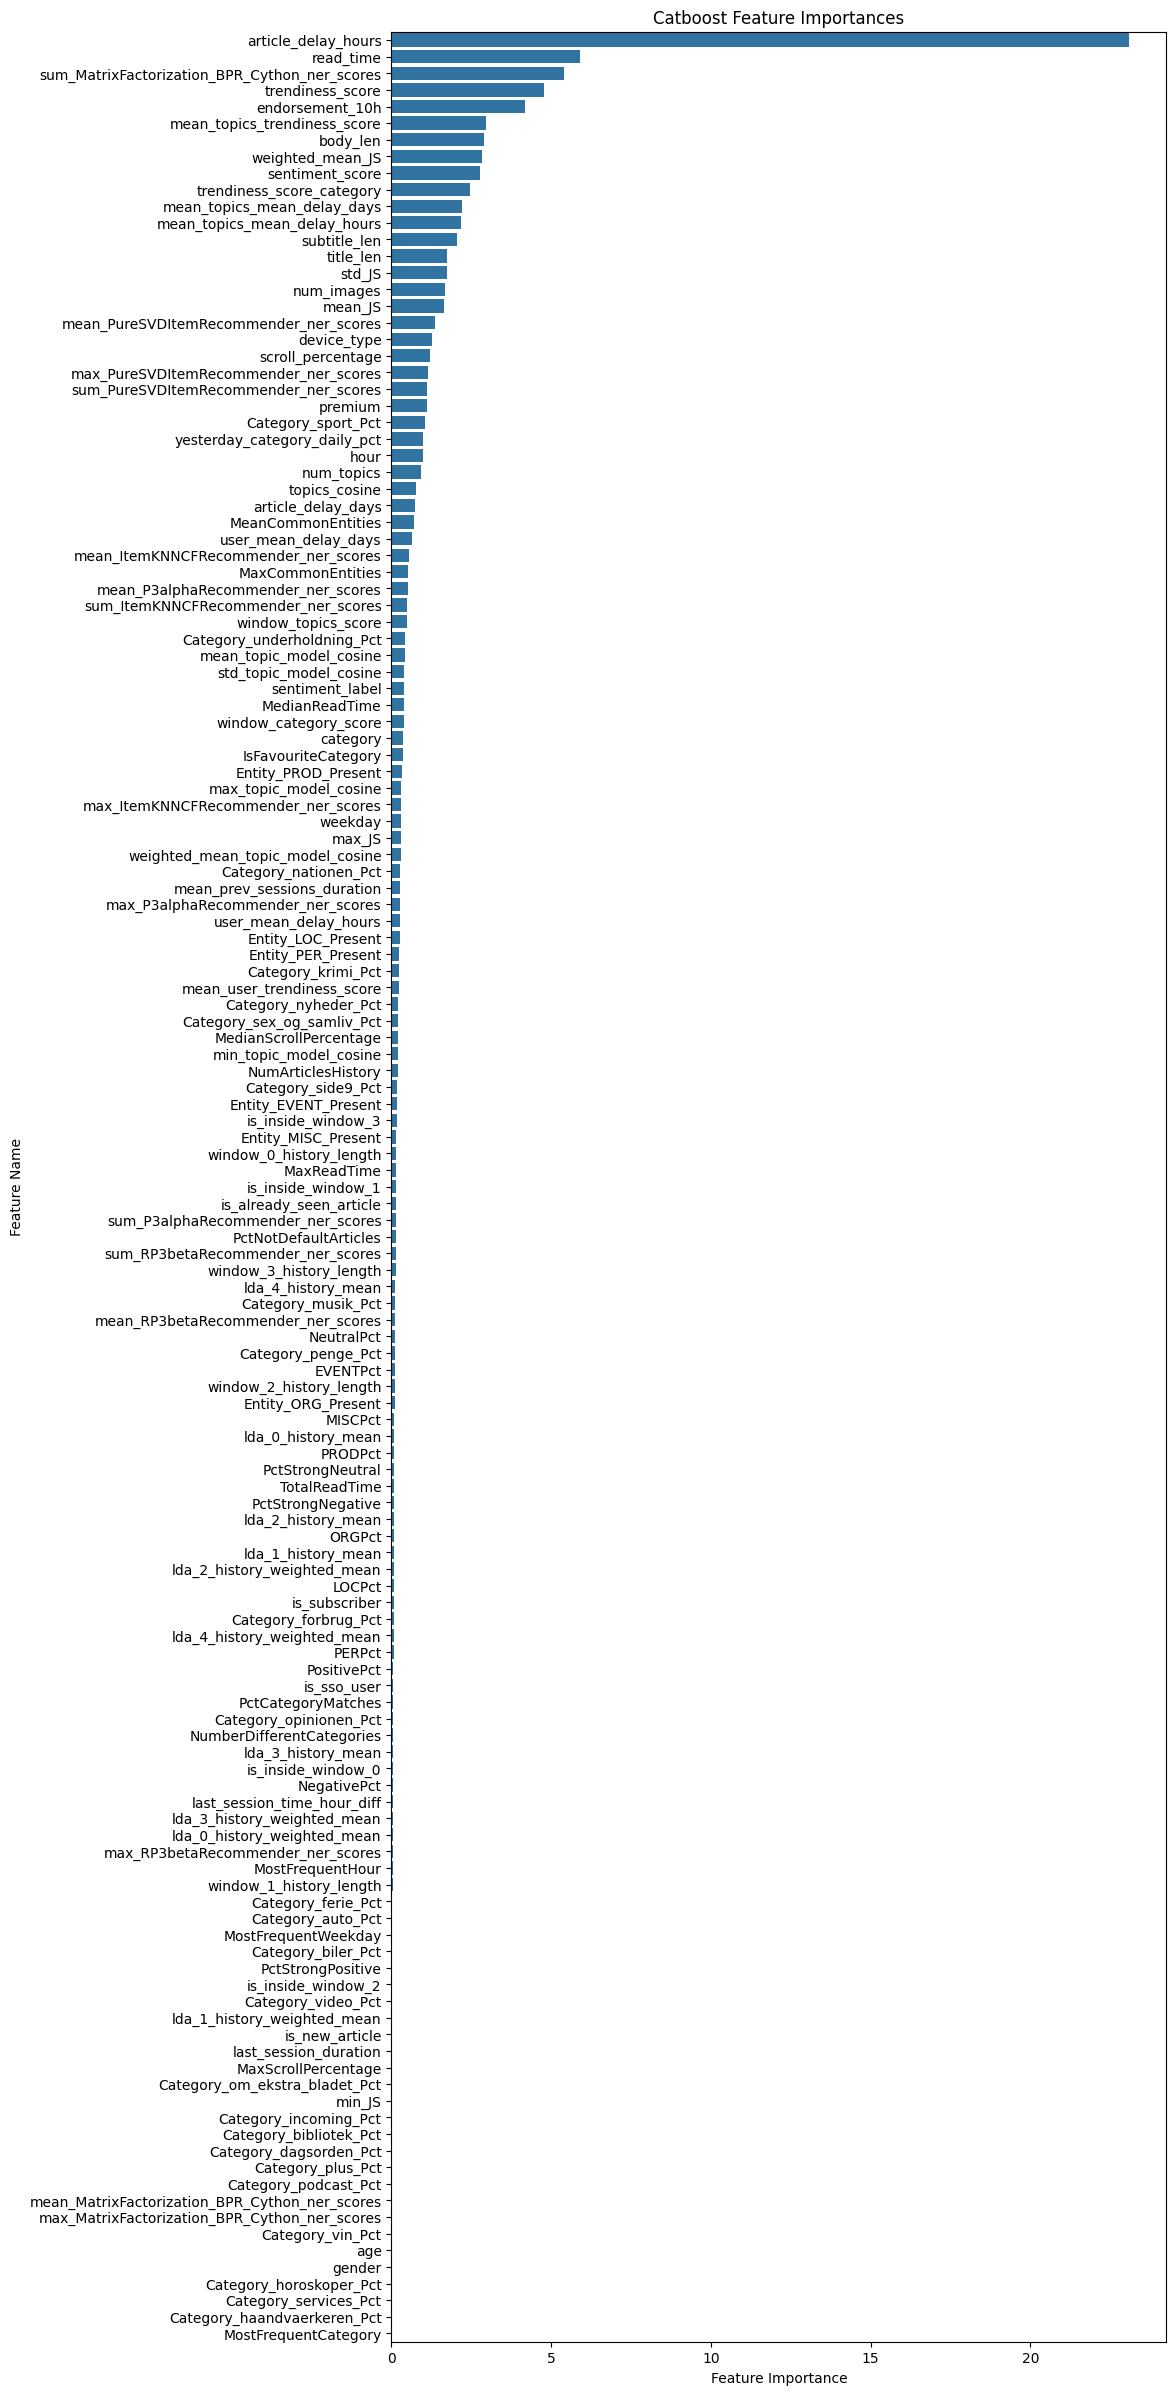

In [13]:
sorted_importances = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 30))
sns.barplot(x=feature_importances[sorted_importances], y=np.array(X_train.columns)[sorted_importances])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Catboost Feature Importances')

# Evaluate

In [19]:
val_ds_path = preprocessing_path / 'preprocessing_validation_small_127'
val_info = read_json(val_ds_path / 'data_info.json')
val_ds = pl.read_parquet(val_ds_path / 'validation_ds.parquet')
val_ds.head(2)

impression_id,article,user_id,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,target,trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,article_delay_days,article_delay_hours,Entity_PROD_Present,Entity_ORG_Present,Entity_PER_Present,Entity_MISC_Present,Entity_LOC_Present,Entity_EVENT_Present,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct,…,Category_sex_og_samliv_Pct,Category_video_Pct,Category_nationen_Pct,mean_user_trendiness_score,mean_topics_trendiness_score,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,weighted_mean_JS,mean_topic_model_cosine,min_topic_model_cosine,max_topic_model_cosine,std_topic_model_cosine,weighted_mean_topic_model_cosine,lda_0_history_mean,lda_1_history_mean,lda_2_history_mean,lda_3_history_mean,lda_4_history_mean,lda_0_history_weighted_mean,lda_1_history_weighted_mean,lda_2_history_weighted_mean,lda_3_history_weighted_mean,lda_4_history_weighted_mean
u32,i32,u32,i8,f32,f32,bool,i8,i8,bool,i8,i16,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,u32,i16,i32,bool,bool,bool,bool,bool,bool,i8,f32,i16,bool,bool,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
152218924,9581248,1551110,1,48.0,null,false,2,null,false,0,70,1,16,true,140,0.993,"""Negative""",6,5,21,696,2,139,3359,false,true,false,false,true,false,1,0.5,-60,true,false,0.106195,…,0.0,0.0,0.04186,201.148834,159.946533,10.069286,244.269562,0.069767,4.055814,34,67,88,60,0,1,0,0,14,23,39,446,0.118492,0.751289,0.439512,0.99834,0.129263,0.751899,0.197715,0.151007,0.24822,0.20829,0.194768,0.196474,0.150314,0.241067,0.214967,0.197179
6023132,9781848,108751,2,9.0,null,false,2,null,false,0,283,5,7,false,142,0.9612,"""Negative""",2,3,15,337,3,0,0,false,true,true,false,true,true,0,1.423077,-6,true,false,0.235772,…,0.0,0.0,0.025478,258.912109,376.573792,5.160991,126.33223,1.038217,26.540127,395,320,116,46,1,0,0,0,118,370,97,11,0.181884,0.813657,0.513151,0.997972,0.111379,0.810134,0.19653,0.151019,0.209977,0.238965,0.20351,0.193723,0.15897,0.207682,0.236031,0.203595


In [20]:
val_features = pl.read_parquet(features_path / 'validation' / 'urm_ner_scores.parquet')
val_features.head(2)

impression_id,user_id,article,sum_RP3betaRecommender_ner_scores,sum_PureSVDItemRecommender_ner_scores,sum_ItemKNNCFRecommender_ner_scores,sum_MatrixFactorization_BPR_Cython_ner_scores,sum_P3alphaRecommender_ner_scores,max_RP3betaRecommender_ner_scores,max_PureSVDItemRecommender_ner_scores,max_ItemKNNCFRecommender_ner_scores,max_MatrixFactorization_BPR_Cython_ner_scores,max_P3alphaRecommender_ner_scores,mean_RP3betaRecommender_ner_scores,mean_PureSVDItemRecommender_ner_scores,mean_ItemKNNCFRecommender_ner_scores,mean_MatrixFactorization_BPR_Cython_ner_scores,mean_P3alphaRecommender_ner_scores
u32,u32,i32,f32,f32,f32,f64,f32,f32,f32,f32,f64,f32,f32,f32,f32,f64,f32
96791,22548,9783865,0.079666,0.085871,0.095643,1.714286,0.026414,0.111974,0.136606,0.111264,1.0,0.029971,0.05975,0.064403,0.071733,1.0,0.01981
96791,22548,9784591,0.464435,0.551501,0.643859,1.0,0.577347,1.0,1.0,1.0,1.0,1.0,0.597131,0.709073,0.827818,1.0,0.742303


In [21]:
val_ds = val_ds.join(val_features, on=['impression_id', 'user_id', 'article'], how='left')
val_ds.head(2)

impression_id,article,user_id,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,target,trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,article_delay_days,article_delay_hours,Entity_PROD_Present,Entity_ORG_Present,Entity_PER_Present,Entity_MISC_Present,Entity_LOC_Present,Entity_EVENT_Present,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct,…,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,weighted_mean_JS,mean_topic_model_cosine,min_topic_model_cosine,max_topic_model_cosine,std_topic_model_cosine,weighted_mean_topic_model_cosine,lda_0_history_mean,lda_1_history_mean,lda_2_history_mean,lda_3_history_mean,lda_4_history_mean,lda_0_history_weighted_mean,lda_1_history_weighted_mean,lda_2_history_weighted_mean,lda_3_history_weighted_mean,lda_4_history_weighted_mean,sum_RP3betaRecommender_ner_scores,sum_PureSVDItemRecommender_ner_scores,sum_ItemKNNCFRecommender_ner_scores,sum_MatrixFactorization_BPR_Cython_ner_scores,sum_P3alphaRecommender_ner_scores,max_RP3betaRecommender_ner_scores,max_PureSVDItemRecommender_ner_scores,max_ItemKNNCFRecommender_ner_scores,max_MatrixFactorization_BPR_Cython_ner_scores,max_P3alphaRecommender_ner_scores,mean_RP3betaRecommender_ner_scores,mean_PureSVDItemRecommender_ner_scores,mean_ItemKNNCFRecommender_ner_scores,mean_MatrixFactorization_BPR_Cython_ner_scores,mean_P3alphaRecommender_ner_scores
u32,i32,u32,i8,f32,f32,bool,i8,i8,bool,i8,i16,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,u32,i16,i32,bool,bool,bool,bool,bool,bool,i8,f32,i16,bool,bool,f32,…,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f32,f32,f32,f32,f64,f32,f32,f32,f32,f64,f32
152218924,9581248,1551110,1,48.0,null,false,2,null,false,0,70,1,16,true,140,0.993,"""Negative""",6,5,21,696,2,139,3359,false,true,false,false,true,false,1,0.5,-60,true,false,0.106195,…,0,0,14,23,39,446,0.118492,0.751289,0.439512,0.99834,0.129263,0.751899,0.197715,0.151007,0.24822,0.20829,0.194768,0.196474,0.150314,0.241067,0.214967,0.197179,0.462672,0.356153,0.492452,3.5,0.674252,1.0,1.0,1.0,1.0,1.0,0.882752,0.861198,0.970147,1.0,0.895341
6023132,9781848,108751,2,9.0,null,false,2,null,false,0,283,5,7,false,142,0.9612,"""Negative""",2,3,15,337,3,0,0,false,true,true,false,true,true,0,1.423077,-6,true,false,0.235772,…,0,0,118,370,97,11,0.181884,0.813657,0.513151,0.997972,0.111379,0.810134,0.19653,0.151019,0.209977,0.238965,0.20351,0.193723,0.15897,0.207682,0.236031,0.203595,0.337981,0.295064,0.407492,2.2,0.241321,0.334423,0.382363,0.32098,1.0,0.187018,0.35092,0.348712,0.421253,1.0,0.17097


In [22]:
val_ds_pandas = val_ds.drop(['impression_id', 'article', 'user_id', 'impression_time']).to_pandas()

categorical_columns = val_info['categorical_columns']
val_ds_pandas[categorical_columns] = val_ds_pandas[categorical_columns].astype('category')

X_val = val_ds_pandas.drop(columns=['target'])
y_val = val_ds_pandas['target']

In [23]:
val_ds = val_ds.with_columns(pl.Series(model.predict_proba(X_val)[:, 1]).alias('prediction'))
val_ds.select(['impression_id', 'target', 'prediction'])

impression_id,target,prediction
u32,i8,f64
152218924,0,0.007399
6023132,0,0.377946
98943105,0,0.242254
285361101,0,0.155667
280914651,0,0.009909
…,…,…
357503649,0,0.277262
129630616,0,0.018435
243313027,0,0.085117


In [24]:
evaluation_ds = val_ds.group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
evaluation_ds

impression_id,target,prediction
u32,list[i8],list[f64]
348531293,"[0, 0, … 0]","[0.036892, 0.11537, … 0.029732]"
48021678,"[0, 1, … 0]","[0.038006, 0.192586, … 0.123852]"
394662659,"[0, 0, … 0]","[0.118809, 0.011817, … 0.009344]"
42279091,"[0, 0, … 0]","[0.250448, 0.036428, … 0.007381]"
385812803,"[0, 0, … 0]","[0.012282, 0.022681, … 0.436193]"
…,…,…
399475344,"[0, 0, … 0]","[0.002863, 0.119527, … 0.003201]"
487646921,"[1, 0, … 0]","[0.017109, 0.192075, … 0.003194]"
419495818,"[0, 0, … 0]","[0.067122, 0.008753, … 0.026041]"


In [25]:
%%time

met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['prediction'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

CPU times: user 1min 45s, sys: 520 ms, total: 1min 45s
Wall time: 1min 48s


<MetricEvaluator class>: 
 {
    "auc": 0.6927058800913705,
    "mrr": 0.46446877006677517,
    "ndcg@5": 0.5195920785889891,
    "ndcg@10": 0.5697743996011575
}